In [109]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")  # Go up one directory level

from src.torch_utils import train_model, plot_training_history

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

from tqdm import tqdm
from torchinfo import summary
from torchvision import datasets, transforms
from torch.utils.data import (
    Subset,
    random_split,
    DataLoader,
    TensorDataset
)

seed = 7
generator = torch.Generator().manual_seed(7)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
generator = torch.Generator().manual_seed(seed)

In [66]:
print(f"Is MPS available: {torch.backends.mps.is_available()}")
print(f"MPS device exists: {torch.backends.mps.is_built()}")

Is MPS available: True
MPS device exists: True


## Prepare Data Directories

In [67]:
base_path = "../data/dogs-vs-cats-all/"

In [68]:
os.makedirs(os.path.join(base_path, "working/train"), exist_ok=True)
os.makedirs(os.path.join(base_path, "working/train/dogs"), exist_ok=True)
os.makedirs(os.path.join(base_path, "working/train/cats"), exist_ok=True)

In [69]:
for train_img in os.listdir(os.path.join(base_path, "train")):
    src = os.path.join(base_path, "train", train_img)
    
    if train_img.startswith("dog"):
        dst = os.path.join(base_path, "working/train/dogs", train_img)
    elif train_img.startswith("cat"):
        dst = os.path.join(base_path, "working/train/cats", train_img)
    
    os.rename(src, dst)

## Create DataLoaders

In [70]:
# IMAGE_SIZE = 150
# BATCH_SIZE = 64

In [88]:
IMAGE_SIZE = 150

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(os.path.join(base_path, "working/train"), transform=transform)

In [89]:
subset_size = 500
full_size = len(dataset)

subset_indices = random.sample(range(full_size), subset_size)
subset_dataset = Subset(dataset, subset_indices)

In [90]:
train_size = int(0.8 * len(subset_dataset))
val_size = len(subset_dataset) - train_size

train_dataset, val_dataset = random_split(
    subset_dataset,
    [train_size, val_size],
    generator=generator
)

In [91]:
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Train Model: Two-Stage Approach
- Extracts features first, then trains classifier
- Data augmentation not possible here

### Feature Extraction

In [92]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(DEVICE)

mps


In [93]:
vgg16 = models.vgg16(pretrained=True)
vgg16.eval()

summary(vgg16, input_size=(1, 3, IMAGE_SIZE, IMAGE_SIZE))

/Users/kate/Documents/repos/ml-boilerplate/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/kate/Documents/repos/ml-boilerplate/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 4, 4]            --
│    └─Conv2d: 2-1                       [1, 64, 150, 150]         1,792
│    └─ReLU: 2-2                         [1, 64, 150, 150]         --
│    └─Conv2d: 2-3                       [1, 64, 150, 150]         36,928
│    └─ReLU: 2-4                         [1, 64, 150, 150]         --
│    └─MaxPool2d: 2-5                    [1, 64, 75, 75]           --
│    └─Conv2d: 2-6                       [1, 128, 75, 75]          73,856
│    └─ReLU: 2-7                         [1, 128, 75, 75]          --
│    └─Conv2d: 2-8                       [1, 128, 75, 75]          147,584
│    └─ReLU: 2-9                         [1, 128, 75, 75]          --
│    └─MaxPool2d: 2-10                   [1, 128, 37, 37]          --
│    └─Conv2d: 2-11                      [1, 256, 37, 37]          29

In [94]:
feature_extractor = vgg16.features.to(DEVICE)
feature_extractor.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [95]:
## EXTRACT FEATURES

def extract_features(dataloader, num_samples):
    """Extract features from images using pretrained model"""
    
    sample_batch, _ = next(iter(dataloader))
    sample_input = sample_batch[0:1].to(DEVICE)
    
    with torch.no_grad():
        sample_output = feature_extractor(sample_input)
        
    _, num_channels, height, width = sample_output.shape
    print(f"Feature shape from pretrained model: {sample_output.shape} for input shape {sample_input.shape}")
    
    features = torch.zeros((num_samples, num_channels, height, width))
    labels = torch.zeros(num_samples)
    
    new_dataloader = DataLoader(
        dataloader.dataset,
        batch_size=dataloader.batch_size,
        shuffle=False
    )
    
    count = 0
    with torch.no_grad():
        for inputs, targets in tqdm(new_dataloader):
            batch_size = min(inputs.size(0), num_samples - count)
            if batch_size <= 0:
                break
                
            batch_features = feature_extractor(inputs[:batch_size].to(DEVICE))
            features[count:count+batch_size] = batch_features.cpu()
            labels[count:count+batch_size] = targets[:batch_size]
            count += batch_size
    
    feature_dim = num_channels * height * width
    features_flat = features.view(num_samples, feature_dim)
    
    return features_flat, labels

In [96]:
train_features, train_labels = extract_features(train_loader, train_size)
val_features, val_labels = extract_features(val_loader, val_size)

Feature shape from pretrained model: torch.Size([1, 512, 4, 4]) for input shape torch.Size([1, 3, 150, 150])


100%|██████████| 7/7 [00:06<00:00,  1.11it/s]


Feature shape from pretrained model: torch.Size([1, 512, 4, 4]) for input shape torch.Size([1, 3, 150, 150])


100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


### Classifier Training

In [99]:
train_dataset = TensorDataset(train_features, train_labels.unsqueeze(1))
val_dataset = TensorDataset(val_features, val_labels.unsqueeze(1))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [101]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, dropout_rate=0.3):
        super(SimpleClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.classifier(x)

In [102]:
train_features.size(1)

8192

In [104]:
LEARNING_RATE = 2e-5

input_dim = train_features.size(1)
model = SimpleClassifier(input_dim).to(DEVICE)
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

In [107]:
history, trained_model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=DEVICE,
    num_epochs=10,
)


Epoch 1/10
--------------------


Epoch 1/10 [Val]: 100%|██████████| 2/2 [00:00<00:00,  7.12it/s, loss=0.2938, acc=0.9300]


Train Loss: 0.4566 | Train Acc: 0.8225
Val Loss: 0.2938 | Val Acc: 0.9300
New best model (val_loss: 0.2938)

Epoch 2/10
--------------------


Epoch 2/10 [Val]: 100%|██████████| 2/2 [00:00<00:00, 297.13it/s, loss=0.2526, acc=0.9400]


Train Loss: 0.2258 | Train Acc: 0.9550
Val Loss: 0.2526 | Val Acc: 0.9400
New best model (val_loss: 0.2526)

Epoch 3/10
--------------------


Epoch 3/10 [Val]: 100%|██████████| 2/2 [00:00<00:00, 251.57it/s, loss=0.2179, acc=0.9300]


Train Loss: 0.1714 | Train Acc: 0.9600
Val Loss: 0.2179 | Val Acc: 0.9300
New best model (val_loss: 0.2179)

Epoch 4/10
--------------------


Epoch 4/10 [Val]: 100%|██████████| 2/2 [00:00<00:00, 131.24it/s, loss=0.2055, acc=0.9300]


Train Loss: 0.1370 | Train Acc: 0.9850
Val Loss: 0.2055 | Val Acc: 0.9300
New best model (val_loss: 0.2055)

Epoch 5/10
--------------------


Epoch 5/10 [Val]: 100%|██████████| 2/2 [00:00<00:00, 293.51it/s, loss=0.1979, acc=0.9100]


Train Loss: 0.1124 | Train Acc: 0.9850
Val Loss: 0.1979 | Val Acc: 0.9100
New best model (val_loss: 0.1979)

Epoch 6/10
--------------------


Epoch 6/10 [Val]: 100%|██████████| 2/2 [00:00<00:00, 247.77it/s, loss=0.1891, acc=0.9600]


Train Loss: 0.1015 | Train Acc: 0.9950
Val Loss: 0.1891 | Val Acc: 0.9600
New best model (val_loss: 0.1891)

Epoch 7/10
--------------------


Epoch 7/10 [Val]: 100%|██████████| 2/2 [00:00<00:00, 276.21it/s, loss=0.1856, acc=0.9000]


Train Loss: 0.0881 | Train Acc: 0.9975
Val Loss: 0.1856 | Val Acc: 0.9000
New best model (val_loss: 0.1856)

Epoch 8/10
--------------------


Epoch 8/10 [Val]: 100%|██████████| 2/2 [00:00<00:00, 286.42it/s, loss=0.1827, acc=0.9000]


Train Loss: 0.0814 | Train Acc: 1.0000
Val Loss: 0.1827 | Val Acc: 0.9000
New best model (val_loss: 0.1827)

Epoch 9/10
--------------------


Epoch 9/10 [Val]: 100%|██████████| 2/2 [00:00<00:00, 282.08it/s, loss=0.1794, acc=0.9200]


Train Loss: 0.0740 | Train Acc: 0.9975
Val Loss: 0.1794 | Val Acc: 0.9200
New best model (val_loss: 0.1794)

Epoch 10/10
--------------------


Epoch 10/10 [Val]: 100%|██████████| 2/2 [00:00<00:00, 234.85it/s, loss=0.1757, acc=0.9400]


Train Loss: 0.0654 | Train Acc: 0.9975
Val Loss: 0.1757 | Val Acc: 0.9400
New best model (val_loss: 0.1757)

Training completed in 0m 6s
Best validation loss: 0.1757


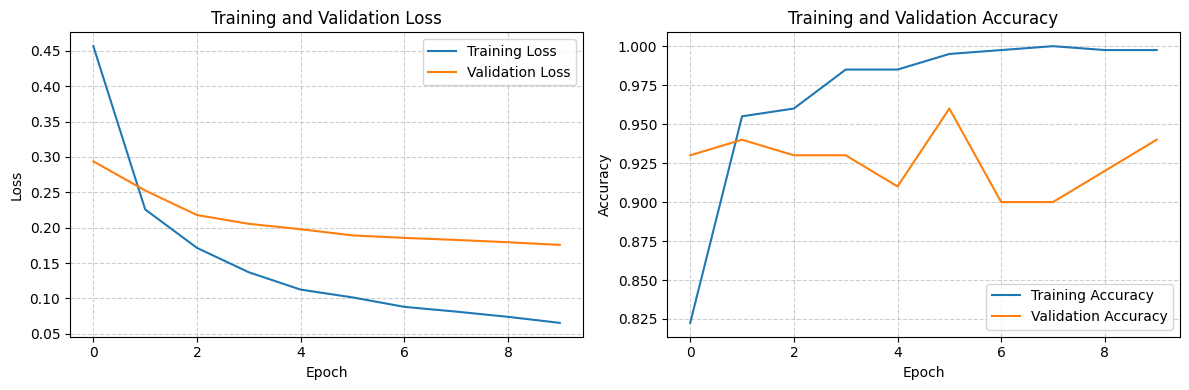

In [110]:
plot_training_history(history)